In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from pathlib import Path
import json
import pickle

import warnings
warnings.filterwarnings("ignore")

In [3]:
ROOT_DIR = Path.cwd().resolve().parent
DATA_DIR = ROOT_DIR / "data"
MODELS_DIR = ROOT_DIR / "models"
PREDICTIONS_DIR = ROOT_DIR / "predictions"

df = pd.read_excel(DATA_DIR / "data1_logs_daily.xlsx", index_col=0)

# 1. Feature Engineering

In [4]:
# 1. Календарные признаки
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['day_of_year'] = df.index.dayofyear
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

df['campaign_days_elapsed'] = df.groupby('year').cumcount() + 1
df['campaign_days_remained'] = df.groupby('year')['campaign_days_elapsed'].transform('max') - df['campaign_days_elapsed']

# 2. Цикличные признаки
df['sin_weekday'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['cos_weekday'] = np.cos(2 * np.pi * df['weekday'] / 7)

# Далее будем преобразовывать только train для предотвращения утечки данных
df = df.reset_index()
train = df[df['year'] < 2024]
test = df[df['year'] == 2024]

# 3. Лаговые признаки
lags = list(range(1, 8))
for lag in lags:
    train[f'y_lag_{lag}'] = train['y'].shift(lag)

# 4. Скользящие средние
windows = [3, 7]
for window in windows:
    train[f'ma_{window}'] = train['y'].shift(1).rolling(window=window).mean()

train = train.dropna().reset_index(drop=True)

X_train = train.drop(columns=['y', 'date'])
X_test = test.drop(columns=['y', 'date'])
y_train = train['y'].values
y_test = test['y'].values

In [4]:
X_train.head()

,year,month,day,weekday,day_of_year,is_weekend,campaign_days_elapsed,campaign_days_remained,sin_weekday,cos_weekday,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,ma_3,ma_7
0,2014,6,27,4,178,0,8,28,-0.433884,-0.900969,512.0,479.0,334.0,308.0,0.0,0.0,56.0,441.666667,241.285714
1,2014,6,28,5,179,1,9,27,-0.974928,-0.222521,498.0,512.0,479.0,334.0,308.0,0.0,0.0,496.333333,304.428571
2,2014,6,29,6,180,1,10,26,-0.781831,0.623490,201.0,498.0,512.0,479.0,334.0,308.0,0.0,403.666667,333.142857
3,2014,6,30,0,181,0,11,25,0.000000,1.000000,0.0,201.0,498.0,512.0,479.0,334.0,308.0,233.000000,333.142857
4,2014,7,1,1,182,0,12,24,0.781831,0.623490,749.0,0.0,201.0,498.0,512.0,479.0,334.0,316.666667,396.142857


In [5]:
def make_forecast(model, X_test, y_test, initial_lags, n_lags=7, mode='recursive'):
    test_df = X_test.reset_index(drop=True)

    forecasts = []
    cur_window = list(initial_lags)

    for idx, row in test_df.iterrows():
        new_features = {
            'year': row['year'],
            'month': row['month'],
            'day': row['day'],
            'weekday': row['weekday'],
            'day_of_year': row['day_of_year'],
            'is_weekend': row['is_weekend'],
            'campaign_days_elapsed': row['campaign_days_elapsed'],
            'campaign_days_remained': row['campaign_days_remained'],
            'sin_weekday': row['sin_weekday'],
            'cos_weekday': row['cos_weekday']
        }
        
        for lag in range(1, n_lags + 1):
            new_features[f'y_lag_{lag}'] = cur_window[-lag]

        new_features['ma_3'] = np.mean(cur_window[-3:]) if len(cur_window) >= 3 else np.mean(cur_window)
        new_features['ma_7'] = np.mean(cur_window[-7:]) if len(cur_window) >= 7 else np.mean(cur_window)

        input_df = pd.DataFrame([new_features])

        y_hat = model.named_steps['regressor'].predict(model.named_steps['feature_selection'].transform(input_df))[0]
        forecasts.append(y_hat)

        cur_window.pop(0)
        if mode == 'iterative':
            cur_window.append(y_test[idx])
        elif mode == 'recursive':
            cur_window.append(y_hat)
        else:
            raise ValueError("Invalid mode. Use 'iterative' or 'recursive'")

    return np.array(forecasts)

def plot(y_pred, y_test, title='', interval=7, figsize=(12, 6), dates=df[df['year'] == 2024]['date']):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(dates, y_test, label='Фактические данные')
    ax.plot(dates, y_pred, label='Прогноз', color='red')
    
    ax.set_xlabel('Дата')
    ax.set_ylabel('Количество заявок')
    ax.set_title(title)

    locator = mdates.DayLocator(interval=interval)
    ax.xaxis.set_major_locator(locator)

    ax.legend()
    ax.grid()
    plt.show()

def print_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")

# 2. Построение моделей

## 2.1. Random Forest Regressor

In [6]:
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [7]:
cv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'feature_selection__k': [5, 10, 15],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
}

In [8]:
gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(score_func=<function f_regression at 0x000001FFBF305900>)),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [5, 10, 15],
                         'regressor__max_depth': [5, 10, None],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [9]:
print(f"Best params: {gs.best_params_}")
print(f"Best score: {-gs.best_score_}")

Best params: {'feature_selection__k': 10, 'regressor__max_depth': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}
Best score: 75.67096532890318


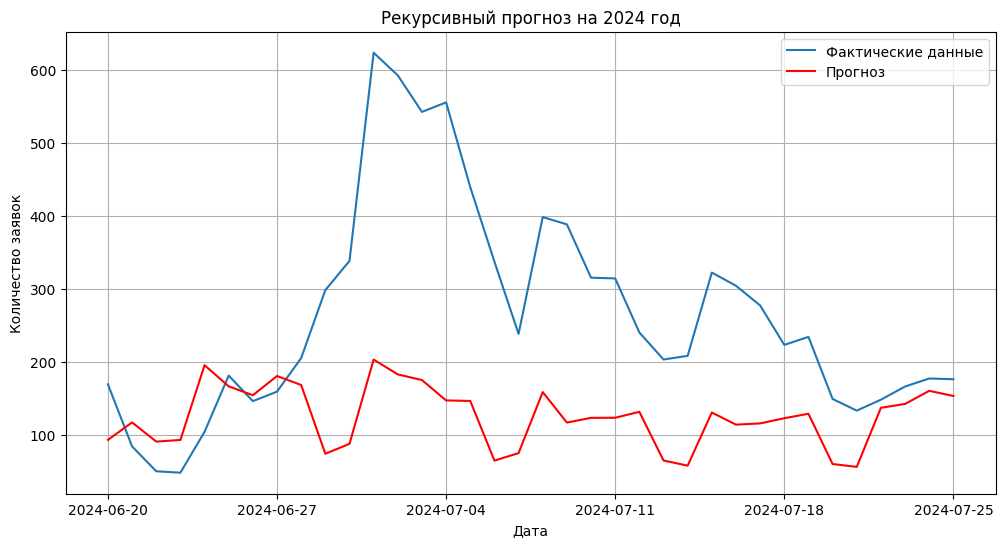

In [10]:
best_model = gs.best_estimator_

n_lags = 7
initial_lags = y_train[-n_lags:]
y_pred_rec = make_forecast(best_model, X_test, y_test, initial_lags, mode='recursive')

dates = df[df['year'] == 2024]['date']

plot(y_pred_rec, y_test, title='Рекурсивный прогноз на 2024 год')

In [11]:
print_metrics(y_test, y_pred_rec)

RMSE: 194.29221353702832
MAE: 151.51926142376144


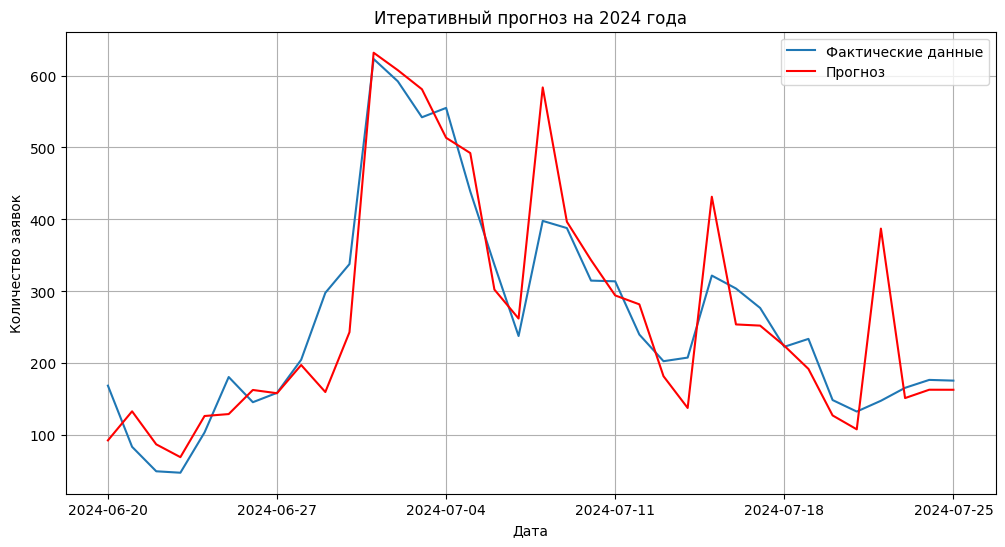

In [12]:
n_lags = 7
initial_lags = y_train[-n_lags:]
y_pred_iter = make_forecast(best_model, X_test, y_test, initial_lags, mode='iterative')

plot(y_pred_iter, y_test, title='Итеративный прогноз на 2024 года')

In [13]:
print_metrics(y_test, y_pred_iter)

RMSE: 68.35687098645187
MAE: 46.146466610549936


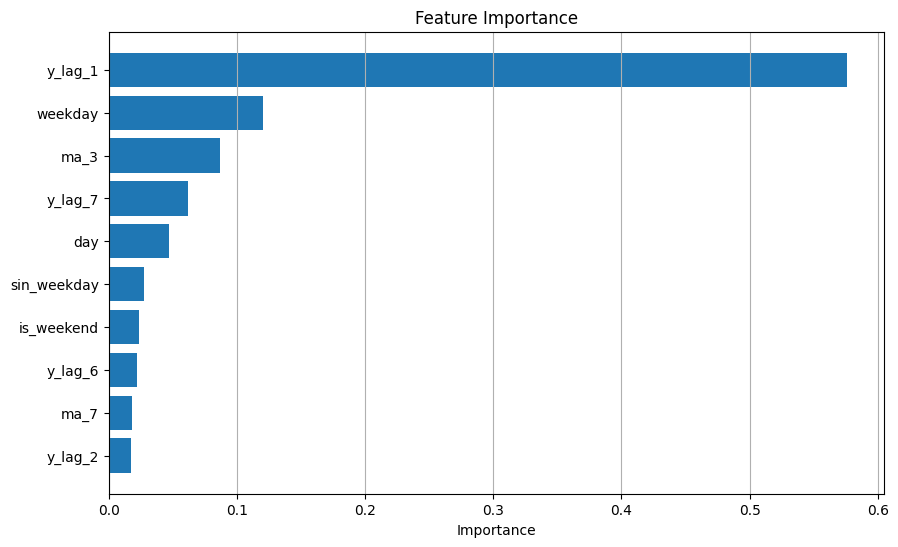

In [14]:
features = X_train.columns[best_model.named_steps['feature_selection'].get_support()]
importances = best_model.named_steps['regressor'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

## 2.2. SVR

In [ ]:
pipeline_svr = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('regressor', SVR())
])

param_grid_svr = {
    'feature_selection__k': [5, 10, 15],
    'regressor__kernel': ['linear', 'rbf'],
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__epsilon': [0.01, 0.1, 0.5, 1]
}

cv = TimeSeriesSplit(n_splits=5)

In [56]:
gs_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
gs_svr.fit(X_train, y_train)

Fitting 10 folds for each of 224 candidates, totalling 2240 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(score_func=<function f_regression at 0x000001A4DB8A6320>)),
                                       ('regressor', SVR())]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [3, 5, 7, 10, 12, 15, 'all'],
                         'regressor__C': [0.1, 1, 10, 100],
                         'regressor__epsilon': [0.01, 0.1, 0.5, 1],
                         'regressor__kernel': ['linear', 'rbf']},
             scoring='neg_root_mean_squared_error', verbose=2)

In [57]:
print(f"Best params: {gs_svr.best_params_}")
print(f"Best score: {-gs.best_score_}")

Best params: {'feature_selection__k': 10, 'regressor__C': 100, 'regressor__epsilon': 0.01, 'regressor__kernel': 'linear'}
Best score: 82.05991919006217


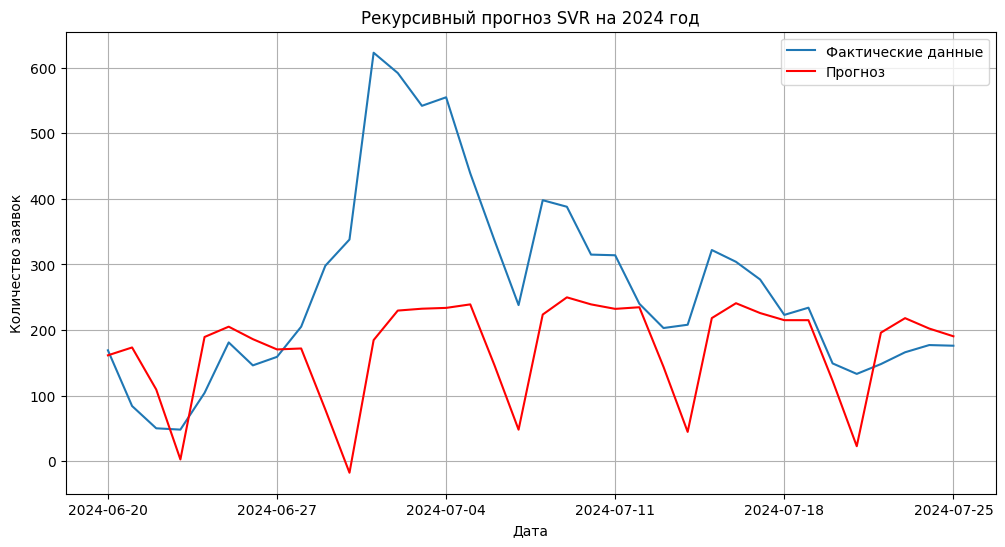

RMSE: 163.5349289795688
MAE: 116.7479392462674


In [58]:
best_model_svr = gs_svr.best_estimator_

initial_lags = y_train[-n_lags:]
y_pred_rec_svr = make_forecast(best_model_svr, X_test, y_test, initial_lags, mode='recursive')

plot(y_pred_rec_svr, y_test, title='Рекурсивный прогноз SVR на 2024 год')
print_metrics(y_test, y_pred_rec_svr)

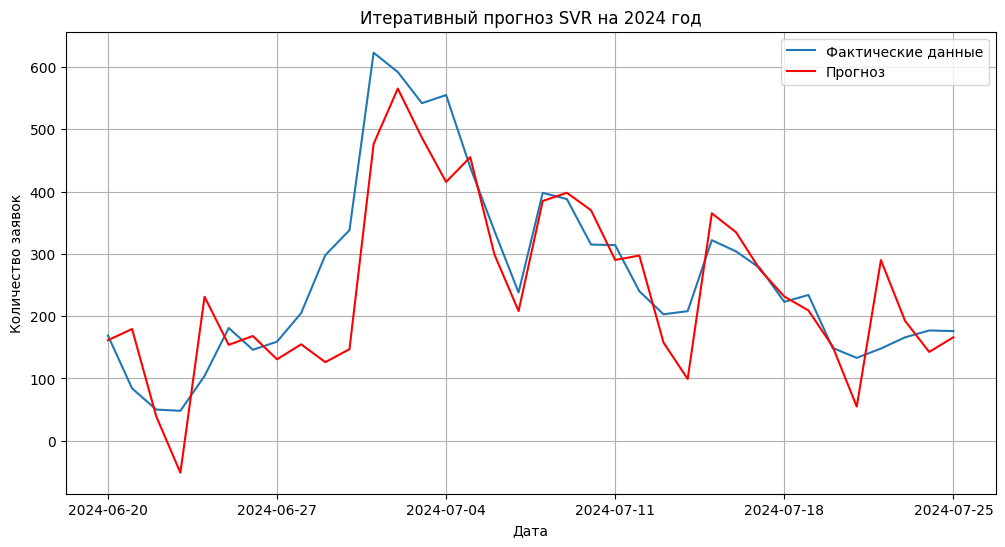

RMSE: 75.64617720785624
MAE: 55.557509140147395


In [59]:
y_pred_iter_svr = make_forecast(best_model_svr, X_test, y_test, initial_lags, mode='iterative')
plot(y_pred_iter_svr, y_test, title='Итеративный прогноз SVR на 2024 год')
print_metrics(y_test, y_pred_iter_svr)

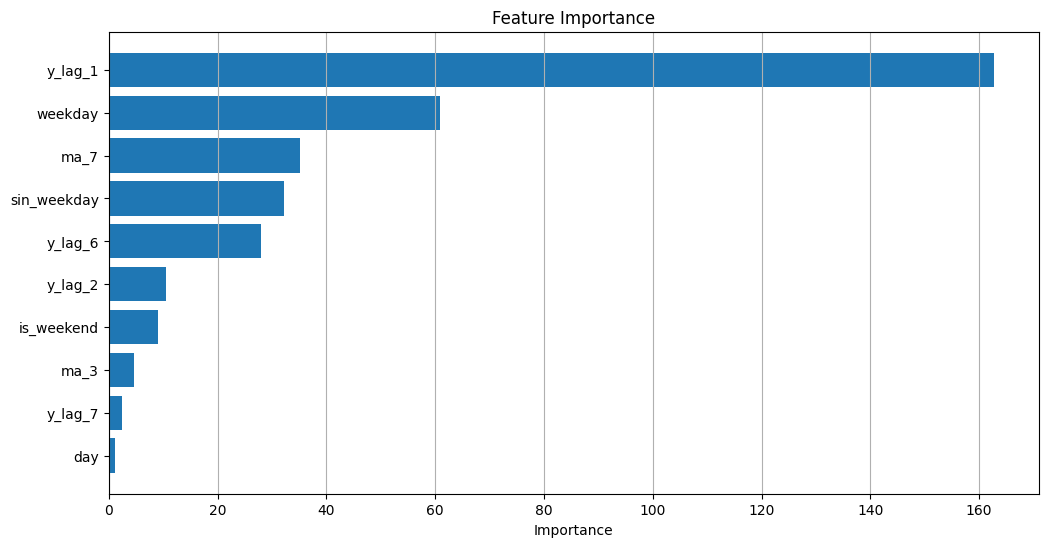

In [ ]:
result = permutation_importance(
    best_model_svr.named_steps['regressor'],
    best_model_svr.named_steps['feature_selection'].transform(X_train),
    y_train,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

features = X_train.columns[best_model_svr.named_steps['feature_selection'].get_support()]
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean
}).sort_values(by='Importance')

plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.grid(axis='x')
plt.show()

## 2.3. XGB Regressor

In [6]:
pipeline_xgb = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('regressor', XGBRegressor(random_state=42))
])

param_grid_xgb = {
    'feature_selection__k': [5, 10, 15],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__subsample': [0.8, 1.0]
}

cv = TimeSeriesSplit(n_splits=5)

In [7]:
gs_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
gs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(score_func=<function f_regression at 0x0000021EA94E5240>)),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     e...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [5, 10, 15],
                         'regressor__learning_rate': [0.01, 0.1, 0.3],
                         'regressor__max_depth': [3, 5, 7],
                         'regressor__n_estimators': [50, 100, 200],
                         'regressor__subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [8]:
print(f"Best params: {gs_xgb.best_params_}")
print(f"Best score: {-gs_xgb.best_score_}")

Best params: {'feature_selection__k': 15, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__subsample': 0.8}
Best score: 77.54742965698242


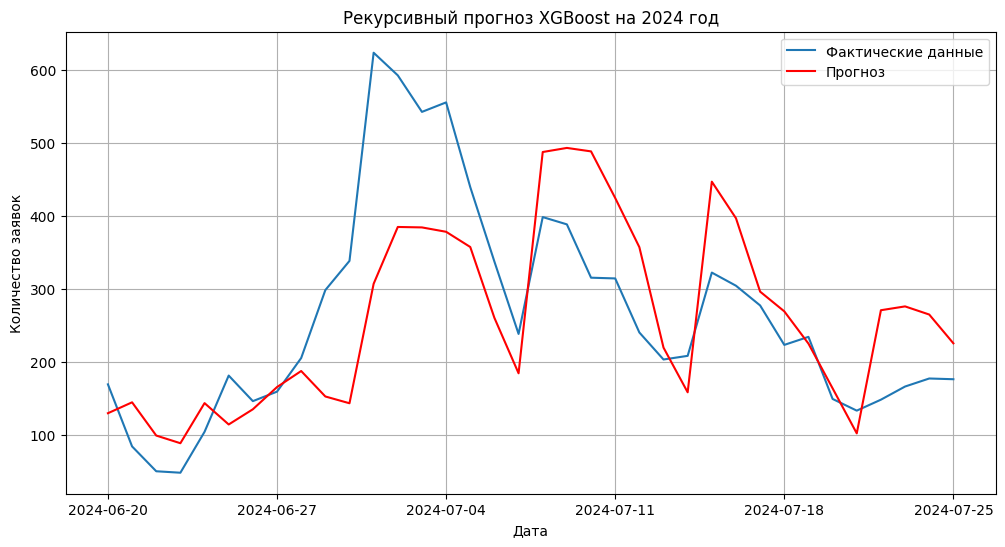

RMSE: 109.57115000794005
MAE: 86.34474182128906


In [9]:
best_model_xgb = gs_xgb.best_estimator_
n_lags = 7
initial_lags = y_train[-n_lags:]
y_pred_rec_xgb = make_forecast(best_model_xgb, X_test, y_test, initial_lags, mode='recursive')
plot(y_pred_rec_xgb, y_test, title='Рекурсивный прогноз XGBoost на 2024 год')
print_metrics(y_test, y_pred_rec_xgb)

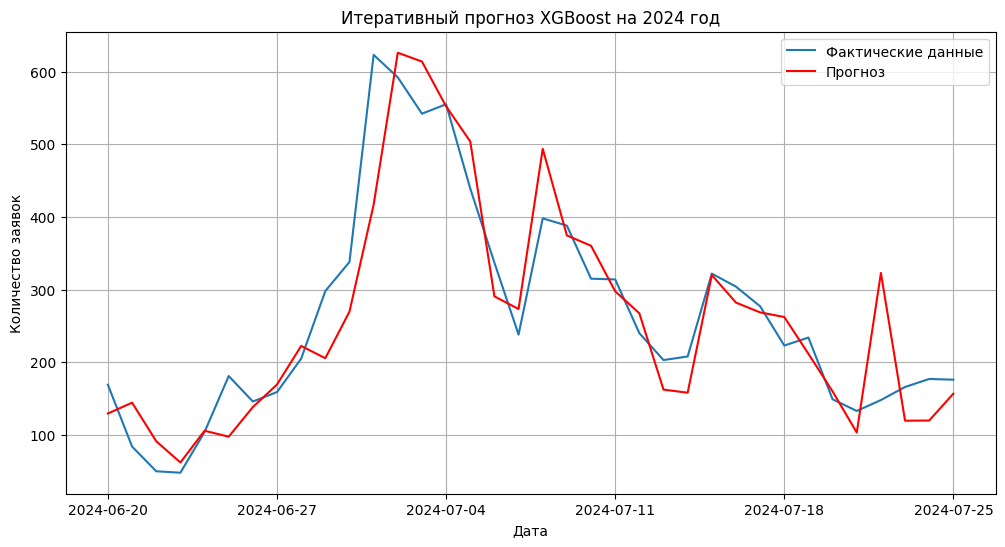

RMSE: 62.511623919076044
MAE: 44.967041015625


In [10]:
y_pred_iter_xgb = make_forecast(best_model_xgb, X_test, y_test, initial_lags, mode='iterative')
plot(y_pred_iter_xgb, y_test, title='Итеративный прогноз XGBoost на 2024 год')
print_metrics(y_test, y_pred_iter_xgb)

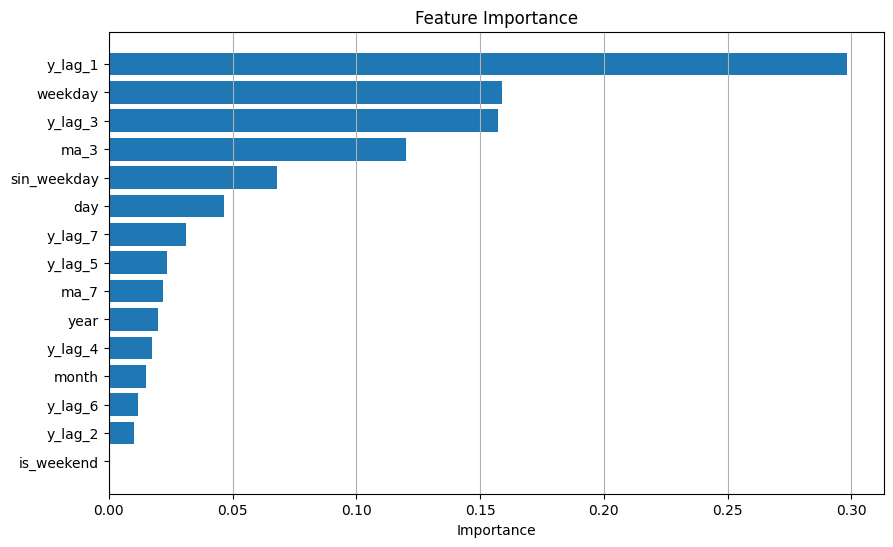

In [11]:
features = X_train.columns[best_model_xgb.named_steps['feature_selection'].get_support()]
importances = best_model_xgb.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance')

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.grid(axis='x')
plt.show()

In [12]:
# Лучшая модель – XGBoost
with open(MODELS_DIR / "xgb_daily_model.pkl", "wb") as file:
    pickle.dump(best_model_xgb, file)

with open(PREDICTIONS_DIR / "xgb_daily_predictions.json", "w") as file:
    json.dump(y_pred_iter_xgb.tolist(), file)

# 3. Дополнительный анализ

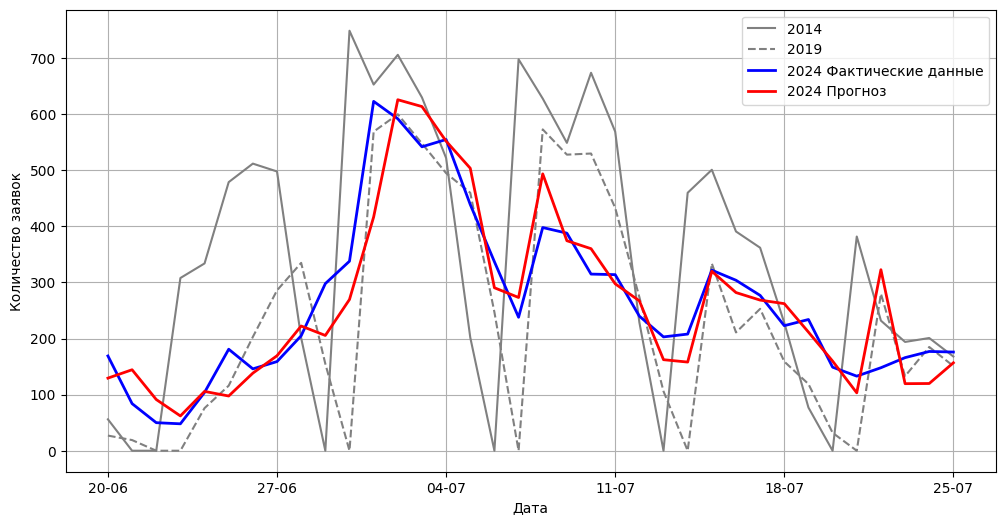

In [21]:
# Последний значимый пик в предсказаниях XGB модели объясняется
# наличием такого пика в большинстве прошлых приемных кампаний
def plot_campaign_comparison(df, hist_years, forecast, actual_year=2024):

    hist_data = {}
    for year in hist_years:
        df_year = df[(df['date'].dt.year == year)].copy()
        df_year['campaign_day'] = df_year['date'].apply(lambda x: x.replace(year=2000))
        agg_df = df_year.groupby('campaign_day')['y'].mean().reset_index()
        hist_data[year] = agg_df

    df_actual = df[(df['date'].dt.year == actual_year)].copy()
    df_actual['campaign_day'] = df_actual['date'].apply(lambda x: x.replace(year=2000))
    df_actual.sort_values('campaign_day', inplace=True)
    
    plt.figure(figsize=(12, 6))

    for i, year in enumerate(hist_years):
        data = hist_data[year]
        ls = '-' if i == 0 else '--'
        plt.plot(data['campaign_day'], data['y'], label=str(year), color='gray', linewidth=1.5, linestyle=ls)
    
    plt.plot(df_actual['campaign_day'], df_actual['y'], 
             label=f"{actual_year} Фактические данные", color='blue', linewidth=2)
    
    plt.plot(df_actual['campaign_day'], forecast, 
             label=f"{actual_year} Прогноз", color='red', linewidth=2)
    
    plt.xlabel('Дата')
    plt.ylabel('Количество заявок')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    
    plt.legend()
    plt.grid(True)
    plt.show()

plot_campaign_comparison(df, [2014, 2019], y_pred_iter_xgb)